# Setup Imports


Code from: https://arena-ch1-transformers.streamlit.app/[1.3]_Indirect_Object_Identification

In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys

if IN_COLAB:
    # Install packages
    %pip install einops
    %pip install jaxtyping
    %pip install transformer_lens
    %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

    # Code to download the necessary files (e.g. solutions, test funcs)
    import os, sys
    if not os.path.exists("chapter1_transformers"):
        !curl -o /content/main.zip https://codeload.github.com/callummcdougall/ARENA_2.0/zip/refs/heads/main
        !unzip /content/main.zip 'ARENA_2.0-main/chapter1_transformers/exercises/*'
        sys.path.append("/content/ARENA_2.0-main/chapter1_transformers/exercises")
        os.remove("/content/main.zip")
        os.rename("ARENA_2.0-main/chapter1_transformers", "chapter1_transformers")
        os.rmdir("ARENA_2.0-main")
        os.chdir("chapter1_transformers/exercises")
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.3/114.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
import os; os.environ["ACCELERATE_DISABLE_RICH"] = "1"
import sys
from pathlib import Path
import torch as t
from torch import Tensor
import numpy as np
import einops
from tqdm.notebook import tqdm
import plotly.express as px
import webbrowser
import re
import itertools
from jaxtyping import Float, Int, Bool
from typing import List, Optional, Callable, Tuple, Dict, Literal, Set
from functools import partial
from IPython.display import display, HTML
from rich.table import Table, Column
from rich import print as rprint
import circuitsvis as cv
from pathlib import Path
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, ActivationCache
from transformer_lens.components import Embed, Unembed, LayerNorm, MLP

t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part3_indirect_object_identification").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, scatter, bar
import part3_indirect_object_identification.tests as tests

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

MAIN = __name__ == "__main__"

/usr/local/lib/python3.10/dist-packages/accelerate/utils/imports.py:197: UserWarning: `ACCELERATE_DISABLE_RICH` is deprecated and will be removed in v0.22.0 and deactivated by default. Please use `ACCELERATE_ENABLE_RICH` if you wish to use `rich`.
  warnings.warn(


In [3]:
from part3_indirect_object_identification.ioi_dataset import NAMES, IOIDataset

# Load Model, Data, and Functions

In [4]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [5]:
# prompt_format = [
#     "When John and Mary went to the shops,{} gave the bag to",
#     "When Tom and James went to the park,{} gave the ball to",
#     "When Dan and Sid went to the shops,{} gave an apple to",
#     "After Martin and Amy went to the park,{} gave a drink to",
# ]
# name_pairs = [
#     (" Mary", " John"),
#     (" Tom", " James"),
#     (" Dan", " Sid"),
#     (" Martin", " Amy"),
# ]

# # Define 8 prompts, in 4 groups of 2 (with adjacent prompts having answers swapped)
# prompts = [
#     prompt.format(name)
#     for (prompt, names) in zip(prompt_format, name_pairs) for name in names[::-1]
# ]
# # Define the answers for each prompt, in the form (correct, incorrect)
# answers = [names[::i] for names in name_pairs for i in (1, -1)]
# # Define the answer tokens (same shape as the answers)
# answer_tokens = t.concat([
#     model.to_tokens(names, prepend_bos=False).T for names in answers
# ])

# rprint(prompts)
# rprint(answers)
# rprint(answer_tokens)

In [6]:
# tokens = model.to_tokens(prompts, prepend_bos=True)
# # Move the tokens to the GPU
# tokens = tokens.to(device)
# # Run the model and cache all activations
# original_logits, cache = model.run_with_cache(tokens)

In [7]:
# def logits_to_ave_logit_diff(
#     logits: Float[Tensor, "batch seq d_vocab"],
#     answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
#     per_prompt: bool = False
# ):
#     '''
#     Returns logit difference between the correct and incorrect answer.

#     If per_prompt=True, return the array of differences rather than the average.
#     '''
#     # Only the final logits are relevant for the answer
#     final_logits: Float[Tensor, "batch d_vocab"] = logits[:, -1, :]
#     # Get the logits corresponding to the indirect object / subject tokens respectively
#     answer_logits: Float[Tensor, "batch 2"] = final_logits.gather(dim=-1, index=answer_tokens)
#     # Find logit difference
#     correct_logits, incorrect_logits = answer_logits.unbind(dim=-1)
#     answer_logit_diff = correct_logits - incorrect_logits
#     return answer_logit_diff if per_prompt else answer_logit_diff.mean()


# tests.test_logits_to_ave_logit_diff(logits_to_ave_logit_diff)

# original_per_prompt_diff = logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
# print("Per prompt logit difference:", original_per_prompt_diff)
# original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
# print("Average logit difference:", original_average_logit_diff)

# cols = [
#     "Prompt",
#     Column("Correct", style="rgb(0,200,0) bold"),
#     Column("Incorrect", style="rgb(255,0,0) bold"),
#     Column("Logit Difference", style="bold")
# ]
# table = Table(*cols, title="Logit differences")

# for prompt, answer, logit_diff in zip(prompts, answers, original_per_prompt_diff):
#     table.add_row(prompt, repr(answer[0]), repr(answer[1]), f"{logit_diff.item():.3f}")

# rprint(table)

# Generate dataset with multiple prompts

In [8]:
class Dataset:
    def __init__(self, prompts, tokenizer, S1_is_first=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        # all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.io_tokenIDs = [
            self.tokenizer.encode(" " + prompt["S5"])[0] for prompt in self.prompts
        ]
        self.s_tokenIDs = [
            self.tokenizer.encode(" " + prompt["S4"])[0] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'S5')]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = model.tokenizer.tokenize(input_text)
                if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                    target_token = prompt[targ]
                else:
                    target_token = "Ġ" + prompt[targ]
                target_index = tokens.index(target_token)
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

Repalce io_tokens with correct answer (next, which is '5') and s_tokens with incorrect (current, which repeats)

In [9]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+3),
            'S5': str(i+4),
            'text': f"{i} {i+1} {i+2} {i+3}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 11)

In [10]:
# use new
# prompts_list_2 = generate_prompts_list(11, 21)

In [11]:
# corrupt by repeating last digit
def generate_corr_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+2),
            'S5': str(i+3),
            'text': f"{i} {i+1} {i+2} {i+2}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list_2 = generate_corr_prompts_list(1, 11)

In [12]:
import torch  # before used 'import torch as t'

In [13]:
# template = "[S1] [S2] [S3] [S4]"
# prompts_list = [{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'S5': '5', 'text': '1 2 3 4'}]

ioi_dataset = Dataset(prompts_list, model.tokenizer, S1_is_first=True)

In [14]:
# template = "[S1] [S2] [S3] [S4]"
# prompts_list = [{'S1': '1', 'S2': '1', 'S3': '1', 'S4': '1', 'S5': '1', 'text': '1 1 1 1'}]

abc_dataset = Dataset(prompts_list_2, model.tokenizer, S1_is_first=True)

## old datasets

In [15]:
# N = 25
# ioi_dataset = IOIDataset(
#     prompt_type="mixed",
#     N=N,
#     tokenizer=model.tokenizer,
#     prepend_bos=False,
#     seed=1,
#     device=str(device)
# )

* `toks` is a tensor of shape `(batch_size, max_seq_len)`
* `s_tokenIDs` and `io_tokenIDs` are lists containing the token IDs for the subjects and objects
* `sentences` is a list containing the sentences (as strings)
* `word_idx` is a dictionary mapping word types (e.g. `"S1"`, `"S2"`, `"IO"` or `"end"`) to tensors containing the positions of those words for each sequence in the dataset.
    * This is particularly handy for indexing, since the positions of the subject, indirect object, and end tokens are not the same in every sentence


Rather than flipping the IOI signal (switch John and Mary), we'll be erasing it. We do this by constructing a new dataset from `ioi_dataset` which replaces every name with a different random name. This way, the sentence structure stays the same, but all information related to the actual indirect object identification  task (i.e. the identities and positions of repeated names) has been erased.

For instance, given the sentence `"When John and Mary went to the shops, John gave the bag to Mary"`, the corresponding sentence in the ABC dataset might be `"When Edward and Laura went to the shops, Adam gave the bag to Mary"`. We would expect the residual stream for the latter prompt to carry no token or positional information which could help it solve the IOI task (i.e. favouring `Mary` over `John`, or favouring the 2nd token over the 4th token).

In [16]:
# abc_dataset = ioi_dataset.gen_flipped_prompts("ABB->XYZ, BAB->XYZ")

## New Metrics

In [17]:
def logits_to_ave_logit_diff_2(logits: Float[Tensor, "batch seq d_vocab"], ioi_dataset: IOIDataset = ioi_dataset, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    io_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), ioi_dataset.word_idx["end"], ioi_dataset.io_tokenIDs]
    s_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), ioi_dataset.word_idx["end"], ioi_dataset.s_tokenIDs]
    # Find logit difference
    answer_logit_diff = io_logits - s_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()


model.reset_hooks(including_permanent=True)

ioi_logits_original, ioi_cache = model.run_with_cache(ioi_dataset.toks)
abc_logits_original, abc_cache = model.run_with_cache(abc_dataset.toks)

ioi_per_prompt_diff = logits_to_ave_logit_diff_2(ioi_logits_original, per_prompt=True)
abc_per_prompt_diff = logits_to_ave_logit_diff_2(abc_logits_original, per_prompt=True)

ioi_average_logit_diff = logits_to_ave_logit_diff_2(ioi_logits_original).item()
abc_average_logit_diff = logits_to_ave_logit_diff_2(abc_logits_original).item()

Note that we're always measuring performance ***with respect to the correct answers for the IOI dataset, not the ABC dataset***, because we want our ABC dataset to carry no information that helps with the IOI task (hence patching it in gives us signals which are totally uncorrelated with the correct answer). For instance, the model will obviously not complete sentences like `"When Max and Victoria got a snack at the store, Clark decided to give it to"` with the name `"Tyler"`.


In [18]:
def ioi_metric_2(
    logits: Float[Tensor, "batch seq d_vocab"],
    clean_logit_diff: float = ioi_average_logit_diff,
    corrupted_logit_diff: float = abc_average_logit_diff,
    ioi_dataset: IOIDataset = ioi_dataset,
) -> float:
    '''
    We calibrate this so that the value is 0 when performance isn't harmed (i.e. same as IOI dataset),
    and -1 when performance has been destroyed (i.e. is same as ABC dataset).
    '''
    patched_logit_diff = logits_to_ave_logit_diff_2(logits, ioi_dataset)
    return (patched_logit_diff - clean_logit_diff) / (clean_logit_diff - corrupted_logit_diff)


print(f"IOI metric (IOI dataset): {ioi_metric_2(ioi_logits_original):.4f}")
print(f"IOI metric (ABC dataset): {ioi_metric_2(abc_logits_original):.4f}")

IOI metric (IOI dataset): 0.0000
IOI metric (ABC dataset): -1.0000


0 means performance is the same as on the IOI dataset (i.e. hasn't been harmed in any way), and -1 means performance is the same as on the ABC dataset (i.e. the model has completely lost the ability to distinguish between the subject and indirect object).


# Path Patching


## Path Patching: Head to Final Value of Residual Stream


We'll start with a simple type of path patching - with just one receiver node, which is the final value of the residual stream.

<details>
<summary>Difference between path patching from an attention head to the residual stream, and activation patching on that attention head?</summary>

Activation patching changes the value of that head, and all subsequent layers which depend on that head.

Path patching will answer the question "what if the value written by the head directly to the residual stream was the same as in $x_{new}$, but every non-direct path from this head to the residual stream (i.e. paths going through other heads) the value was the same as it would have been under $x_{orig}$?
</details>

This patching is described at the start of section 3.1 in [the paper](https://arxiv.org/pdf/2211.00593.pdf) (page 5). The 3-step process will look like:

1. Run the model on clean and corrupted input. Cache the head outputs.
2. Run the model on clean input, with the sender head **patched** from the corrupted input, and every other head **frozen** to their values on the clean input. Cache the final value of the residual stream (i.e. `resid_post` in the final layer).
3. Normally we would re-run the model on the clean input and patch in the cached value of the final residual stream, but in this case we don't need to because we can just unembed the final value of the residual stream directly without having to run another forward pass.

Here is an illustration for a 2-layer transformer:

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/path-patching-residpost-newest.png" width="680">


In [19]:
def patch_or_freeze_head_vectors(
    orig_head_vector: Float[Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    new_cache: ActivationCache,
    orig_cache: ActivationCache,
    head_to_patch: Tuple[int, int],
) -> Float[Tensor, "batch pos head_index d_head"]:
    '''
    This helps implement step 2 of path patching. We freeze all head outputs (i.e. set them
    to their values in orig_cache), except for head_to_patch (if it's in this layer) which
    we patch with the value from new_cache.

    head_to_patch: tuple of (layer, head)
        we can use hook.layer() to check if the head to patch is in this layer
    '''
    # Setting using ..., otherwise changing orig_head_vector will edit cache value too
    orig_head_vector[...] = orig_cache[hook.name][...]
    if head_to_patch[0] == hook.layer():
        orig_head_vector[:, :, head_to_patch[1]] = new_cache[hook.name][:, :, head_to_patch[1]]
    return orig_head_vector

def get_path_patch_head_to_final_resid_post(
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = abc_dataset,
    orig_dataset: IOIDataset = ioi_dataset,
    new_cache: Optional[ActivationCache] = abc_cache,
    orig_cache: Optional[ActivationCache] = ioi_cache,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = final value of residual stream

    Returns:
        tensor of metric values for every possible sender head
    '''
    model.reset_hooks()
    results = t.zeros(model.cfg.n_layers, model.cfg.n_heads, device="cuda", dtype=t.float32)

    resid_post_hook_name = utils.get_act_name("resid_post", model.cfg.n_layers - 1)
    resid_post_name_filter = lambda name: name == resid_post_hook_name


    # ========== Step 1 ==========
    # Gather activations on x_orig and x_new

    # Note the use of names_filter for the run_with_cache function. Using it means we
    # only cache the things we need (in this case, just attn head outputs).
    z_name_filter = lambda name: name.endswith("z")
    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )


    # Looping over every possible sender head (the receiver is always the final resid_post)
    # Note use of itertools (gives us a smoother progress bar)
    for (sender_layer, sender_head) in tqdm(list(itertools.product(range(model.cfg.n_layers), range(model.cfg.n_heads)))):

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            patch_or_freeze_head_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            head_to_patch=(sender_layer, sender_head),
        )
        model.add_hook(z_name_filter, hook_fn)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=resid_post_name_filter,
            return_type=None
        )
        # if (sender_layer, sender_head) == (9, 9):
        #     return patched_cache
        assert set(patched_cache.keys()) == {resid_post_hook_name}

        # ========== Step 3 ==========
        # Unembed the final residual stream value, to get our patched logits

        patched_logits = model.unembed(model.ln_final(patched_cache[resid_post_hook_name]))

        # Save the results
        results[sender_layer, sender_head] = patching_metric(patched_logits)

    return results

In [ ]:
# path_patch_head_to_final_resid_post = get_path_patch_head_to_final_resid_post(model, ioi_metric_2)

In [ ]:
# imshow(
#     100 * path_patch_head_to_final_resid_post,
#     title="Direct effect on logit difference",
#     labels={"x":"Head", "y":"Layer", "color": "Logit diff. variation"},
#     coloraxis=dict(colorbar_ticksuffix = "%"),
#     width=600,
# )

The only reason activation patching would do something different to path patching is if the heads writing in the `Correct_token - Incorrect_token` direction had their outputs used by a later head (because this would be accounted for in activation patching, whereas path patching isolates the direct effect on the residual stream only). When the output is the final value of the residual stream, there is no later (downstream) head, hence activation patching and path patching would be the same in those cases.

## Loop over Path Patching: Head to Head


Here we patch from the output of one head to the input of a later head. The purpose of this is to examine exactly how two heads are composing, and what effect the composed heads have on the model's output.

Activation patching on the values of the certain heads finds that "they were important". But it didn't tell us FROM WHICH INPUTS to these value vectors were important; we had to make educated guesses about this based on our analysis earlier parts of the model. In path patching, we can perform a more precise test to find which heads are important.


`get_path_patch_head_to_head` takes as arguments a list of receiver nodes (as well as the type of input - keys, queries, or values), and returns a tensor of shape\* `(layer, head)` where each element is the result of running the patching metric on the output of the model, after applying the 3-step path patching algorithm from one of the model's heads to all the receiver heads.

\**Actually, you don't need to return all layers, because the causal effect from any sender head which is on the same or a later layer than the last of your receiver heads will necessarily be zero.*

<details>
<summary>Differences from first path patching function</summary>

Step 1 is identical in both - gather all the observations.

Step 2 is very similar. The only difference is that you'll be caching a different set of activations (your receiver heads).

In section 3, since your receiver nodes are in the middle of the model rather than at the very end, you will have to run the model again with these nodes patched in rather than just calculating the logit output directly from the patched values of the final residual stream. To do this, you'll have to write a new hook function to patch in the inputs to an attention head.
</details>


In [20]:
def patch_head_input(
    orig_activation: Float[Tensor, "batch pos head_idx d_head"],
    hook: HookPoint,
    patched_cache: ActivationCache,
    head_list: List[Tuple[int, int]],
) -> Float[Tensor, "batch pos head_idx d_head"]:
    '''
    Function which can patch any combination of heads in layers,
    according to the heads in head_list.
    '''
    heads_to_patch = [head for layer, head in head_list if layer == hook.layer()]
    orig_activation[:, :, heads_to_patch] = patched_cache[hook.name][:, :, heads_to_patch]
    return orig_activation



def get_path_patch_head_to_heads(
    receiver_heads: List[Tuple[int, int]],
    receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = abc_dataset,
    orig_dataset: IOIDataset = ioi_dataset,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    model.reset_hooks()

    assert receiver_input in ("k", "q", "v")
    receiver_layers = set(next(zip(*receiver_heads)))
    receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # Gather activations on x_orig and x_new

    # Note the use of names_filter for the run_with_cache function. Using it means we
    # only cache the things we need (in this case, just attn head outputs).
    z_name_filter = lambda name: name.endswith("z")
    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.
    for (sender_layer, sender_head) in tqdm(list(itertools.product(
        range(max(receiver_layers)),
        range(model.cfg.n_heads)
    ))):

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            patch_or_freeze_head_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            head_to_patch=(sender_layer, sender_head),
        )
        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            patch_head_input,
            patched_cache=patched_cache,
            head_list=receiver_heads,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        results[sender_layer, sender_head] = patching_metric(patched_logits)

    return results

In [ ]:
model.reset_hooks()
results = get_path_patch_head_to_heads(
    receiver_heads = [(9,1)],
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)

  0%|          | 0/108 [00:00<?, ?it/s]

In [ ]:
results.shape

torch.Size([9, 12])

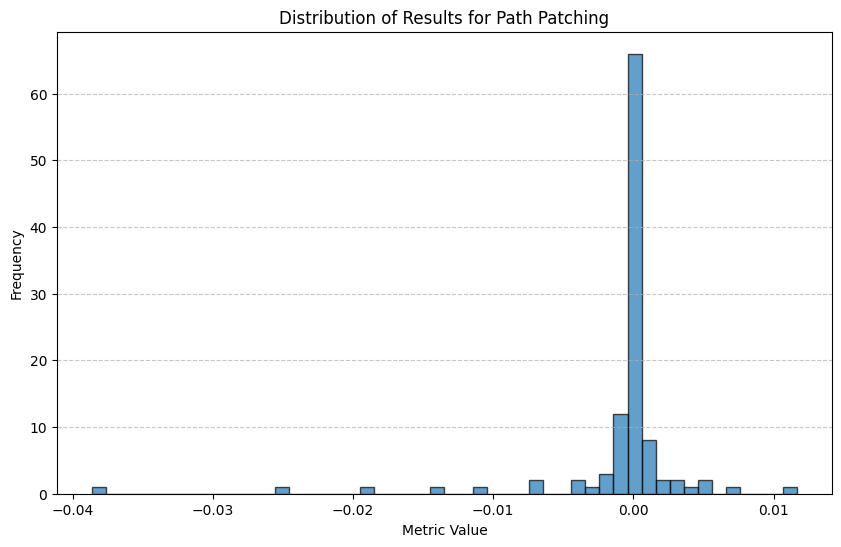

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

results_np = results.cpu().numpy().flatten()  # Convert tensor to numpy and flatten it

plt.figure(figsize=(10, 6))
plt.hist(results_np, bins=50, edgecolor='black', alpha=0.7)
plt.title("Distribution of Results for Path Patching")
plt.xlabel("Metric Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
imshow(
    # 100 * results,
    results,
    title="Direct effect onHeads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

In [ ]:
def top_layer_heads_for_abs(results: torch.Tensor, k: int = 1) -> list:
    """Return the top k (layer, head) pairs based on the absolute values in results."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Ensure k doesn't exceed the number of elements in the tensor
    k = min(k, abs_tensor.numel())

    # Get top k values and their indices
    values, indices = torch.topk(abs_tensor.view(-1), k)

    # Convert 1D indices to 2D (layer, head) pairs
    layers = indices // results.size(1)
    heads = indices % results.size(1)

    return list(zip(layers.tolist(), heads.tolist()))

# Example usage:
top_k = 5
top_abs_pairs = top_layer_heads_for_abs(results, top_k)
print(top_abs_pairs)

[(0, 1), (4, 4), (5, 5), (6, 6), (7, 11)]


In [ ]:
%%capture
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = top_layer_heads_for_abs(result, 5)

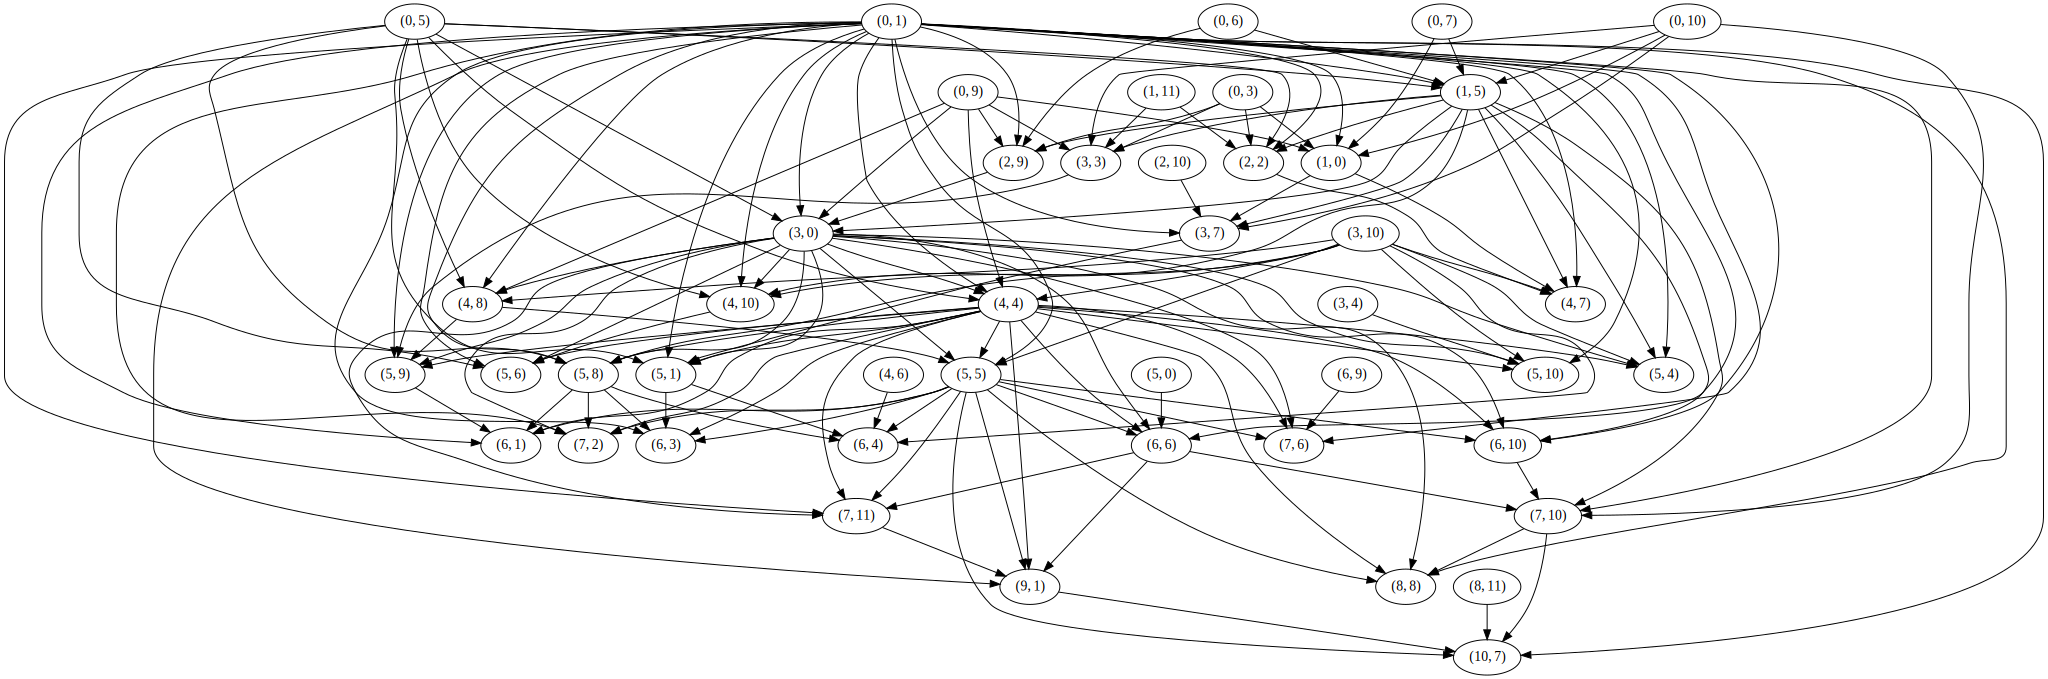

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph"):
    dot = Digraph()

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph
        dot.node(str(end_node))

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph
            dot.node(str(start))
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

plot_graph_adjacency(head_adjList)

In [ ]:
imshow(
    100 * results_dict[(7,11)],
    title="Direct effect on 7.11 Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

In [ ]:
head_adjList[(7,11)]

[(5, 5), (0, 1), (4, 4), (3, 0), (6, 6)]

In [ ]:
import pickle
with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

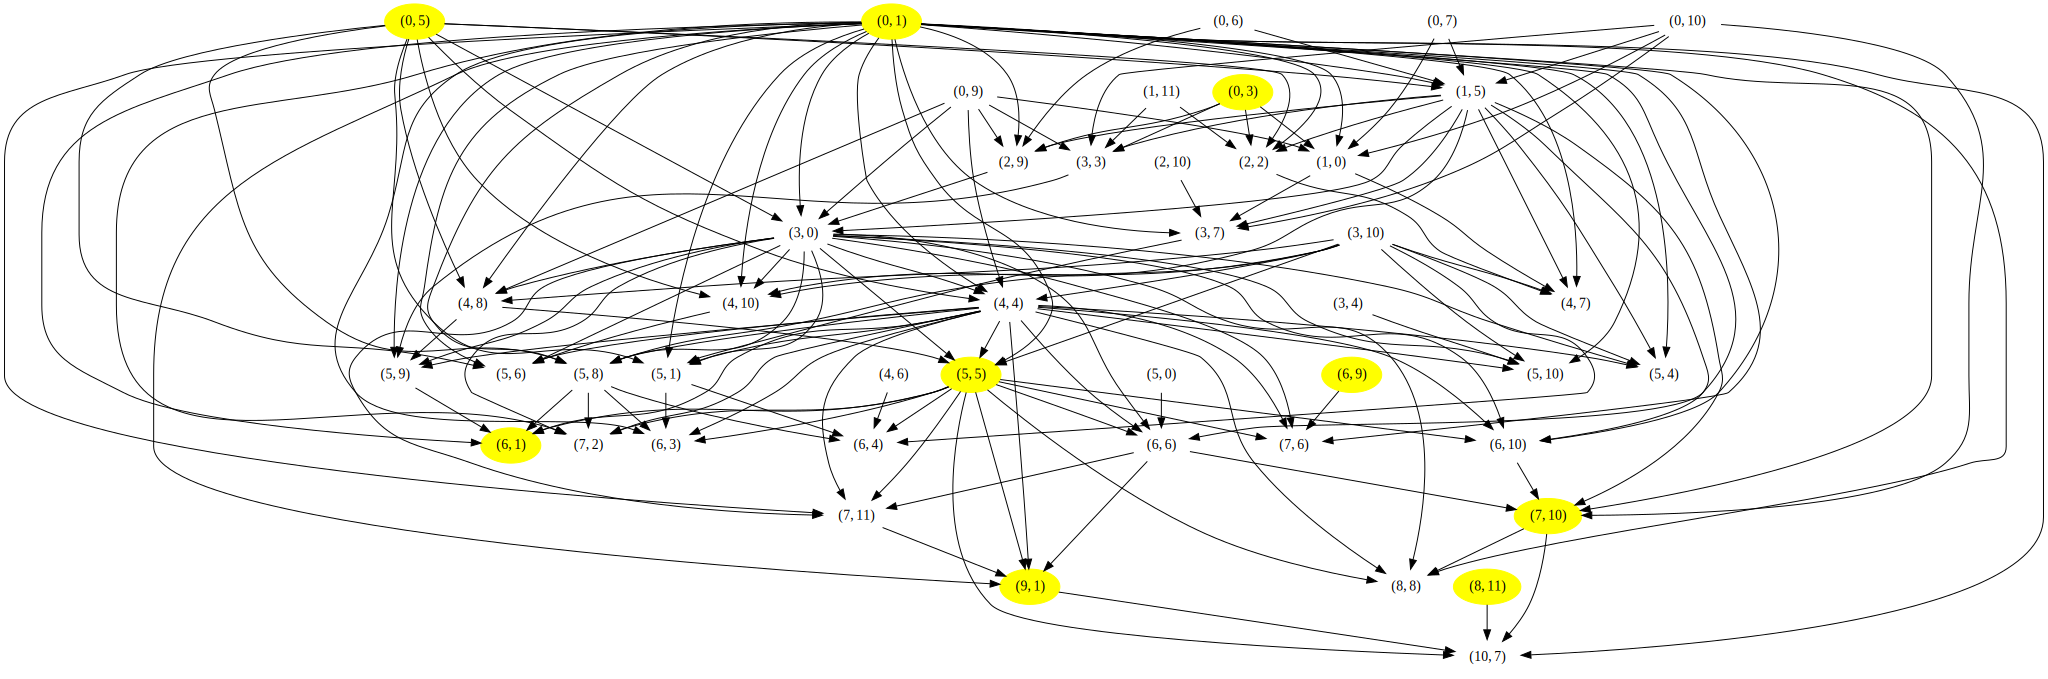

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "yellow" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        dot.node(str(end_node), color=get_node_color(end_node), style='filled')

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph with potential color
            dot.node(str(start), color=get_node_color(start), style='filled')
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)


## Get Edges by Logit Diff Threshold

In [ ]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

### test on head 9.1

In [ ]:
model.reset_hooks()
results = get_path_patch_head_to_heads(
    receiver_heads = [(9,1)],
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)

  0%|          | 0/108 [00:00<?, ?it/s]

In [ ]:
threshold_value = 0.01
pairs_within_threshold = edges_within_threshold(results, threshold_value)
print(pairs_within_threshold)

[(0, 1), (3, 0), (4, 4), (5, 5), (6, 6), (7, 11)]


In [ ]:
%%capture
# circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
circuit = [(9, 1)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = edges_within_threshold(result, threshold_value)

In [ ]:
results[0,1]

tensor(-0.0386, device='cuda:0')

In [ ]:
results[3,0]

tensor(-0.0114, device='cuda:0')

In [ ]:
results

tensor([[-7.6783e-05, -3.8601e-02,  2.8544e-04, -3.7370e-03, -2.4871e-05,
         -6.6799e-03, -2.4120e-04,  7.5466e-04, -4.2529e-04, -1.5855e-03,
          5.2517e-03, -2.1694e-05],
        [ 2.8815e-04,  1.0421e-04,  1.7689e-04,  1.4698e-04,  4.5093e-05,
         -6.9624e-03, -4.5713e-05,  1.3319e-04,  2.2237e-04,  1.5504e-04,
          2.9125e-04, -5.3748e-04],
        [-1.6426e-05,  3.6648e-04, -4.6480e-04, -1.5914e-04, -3.1961e-04,
          3.6524e-04,  1.1064e-04,  8.8281e-04, -8.2129e-05,  1.0243e-04,
          2.5925e-04,  1.5775e-04],
        [-1.1446e-02,  1.3094e-05, -2.4143e-04, -1.2805e-03,  4.3474e-03,
         -2.3066e-04, -5.3531e-04,  4.5016e-04,  5.2222e-05, -3.1922e-05,
          8.7552e-04,  1.5713e-04],
        [ 1.2707e-05,  2.6700e-04, -1.8750e-04,  1.6085e-04, -2.4928e-02,
         -9.2976e-05,  4.4884e-04, -4.2188e-04, -9.6850e-05,  2.3941e-05,
          1.5891e-04,  3.5377e-04],
        [ 6.9066e-04, -2.0385e-04,  1.3032e-04, -8.5693e-05, -8.6266e-04,
      

Anything greater than e-02 is kept

In [ ]:
imshow(
    100 * results_dict[(9,1)],
    title="Direct effect on 9.1 Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

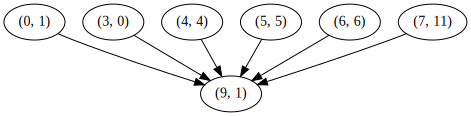

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph"):
    dot = Digraph()

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph
        dot.node(str(end_node))

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph
            dot.node(str(start))
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

plot_graph_adjacency(head_adjList)

### test on head 1.0

In [ ]:
%%capture
# circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
circuit = [(1, 0)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = edges_within_threshold(result, threshold_value)

In [ ]:
results_dict

{(1,
  0): tensor([[ 3.2542e-06,  8.7777e-04, -2.6808e-05, -1.5852e-04,  2.9675e-05,
           6.8957e-06, -3.8972e-05, -5.6870e-05, -4.3156e-05,  1.0584e-04,
          -1.5109e-04,  7.9804e-06]], device='cuda:0')}

In [ ]:
imshow(
    100 * results_dict[(1,0)],
    title="Direct effect on 9.1 Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

### test on circuit from work backw

In [ ]:
%%capture
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
# circuit = [(9, 1)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    # head_adjList[head] = edges_within_threshold(result, threshold_value)

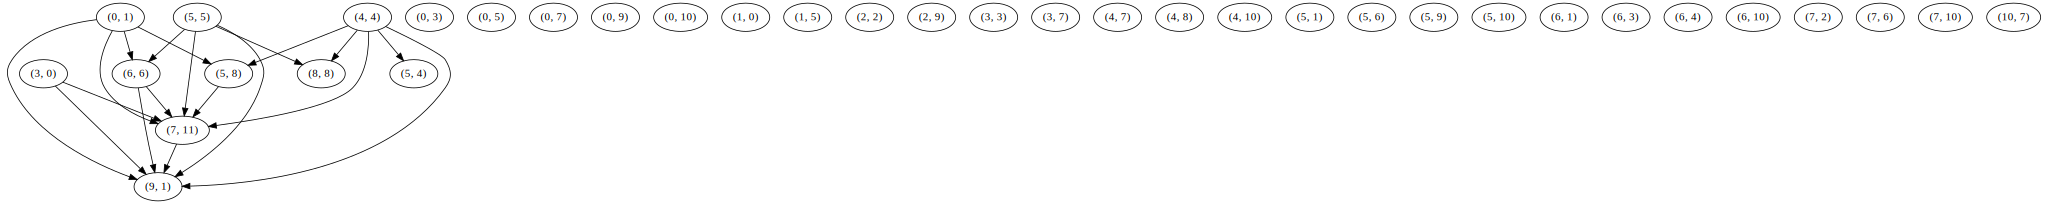

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph"):
    dot = Digraph()

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph
        dot.node(str(end_node))

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph
            dot.node(str(start))
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

plot_graph_adjacency(head_adjList)

In [ ]:
imshow(
    100 * results_dict[(7,11)],
    title="Direct effect on 7.11 Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

In [ ]:
head_adjList[(7,11)]

[(0, 1), (3, 0), (4, 4), (5, 5), (5, 8), (6, 6)]

In [ ]:
imshow(
    # 100 * results_dict[(2, 2)],
    results_dict[(2, 2)],
    title="Direct effect on Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

In [ ]:
model.reset_hooks()
results = get_path_patch_head_to_heads(
    receiver_heads = [(2,2)],
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
threshold_value = 0.01
pairs_within_threshold = edges_within_threshold(results, threshold_value)
print(pairs_within_threshold)

[]


In [ ]:
import pickle
with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

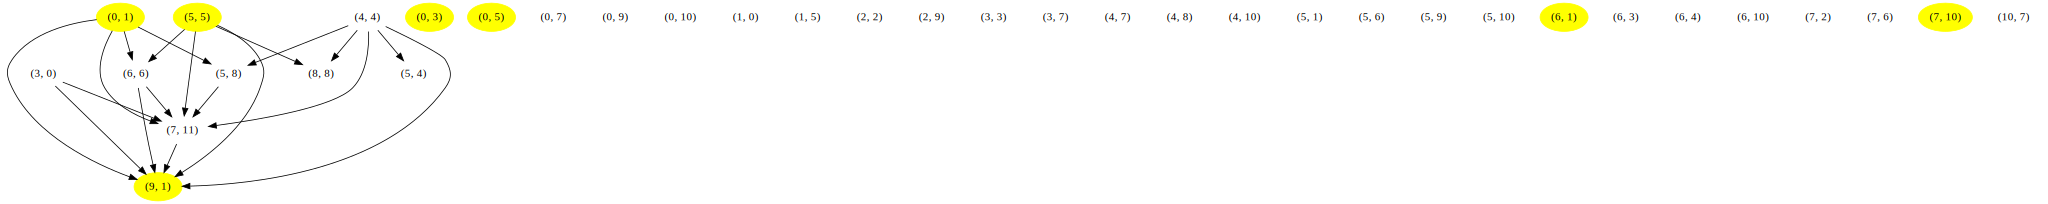

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "yellow" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        dot.node(str(end_node), color=get_node_color(end_node), style='filled')

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph with potential color
            dot.node(str(start), color=get_node_color(start), style='filled')
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)


## plot distribution of all values

In [ ]:
%%capture
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
# circuit = [(9, 1)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    # head_adjList[head] = edges_within_threshold(result, threshold_value)

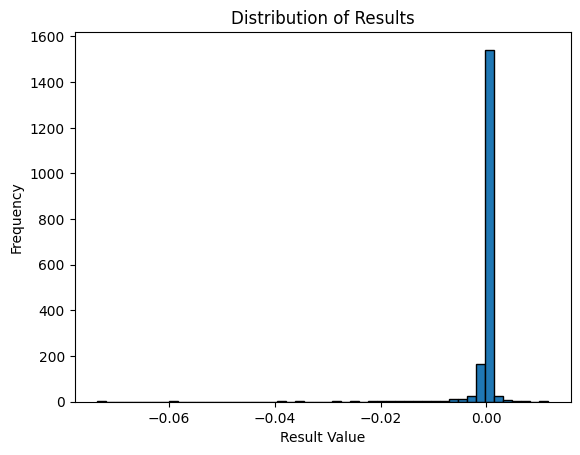

In [ ]:
import matplotlib.pyplot as plt

# Gather all results into a single list
all_values = []
for result_tensor in results_dict.values():
    all_values.extend(result_tensor.cpu().numpy().flatten())

# Plot the distribution
plt.hist(all_values, bins=50, edgecolor='black')
plt.title('Distribution of Results')
plt.xlabel('Result Value')
plt.ylabel('Frequency')
plt.show()

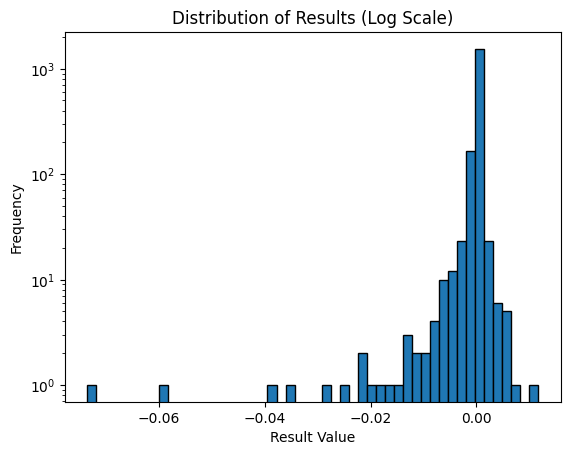

In [ ]:
import matplotlib.pyplot as plt

# Gather all results into a single list
all_values = []
for result_tensor in results_dict.values():
    all_values.extend(result_tensor.cpu().numpy().flatten())

# Plot the distribution
plt.hist(all_values, bins=50, edgecolor='black')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Distribution of Results (Log Scale)')
plt.xlabel('Result Value')
plt.ylabel('Frequency')
plt.show()

## Get Edges by Logit Diff Threshold 0.005

In [ ]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

# Example usage:
threshold_value = 0.005
pairs_within_threshold = edges_within_threshold(results, threshold_value)
print(pairs_within_threshold)

[(0, 1), (0, 5), (0, 10), (1, 5), (3, 0), (4, 4), (5, 5), (6, 6), (6, 9), (7, 10), (7, 11)]


In [ ]:
%%capture
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = edges_within_threshold(result, threshold_value)

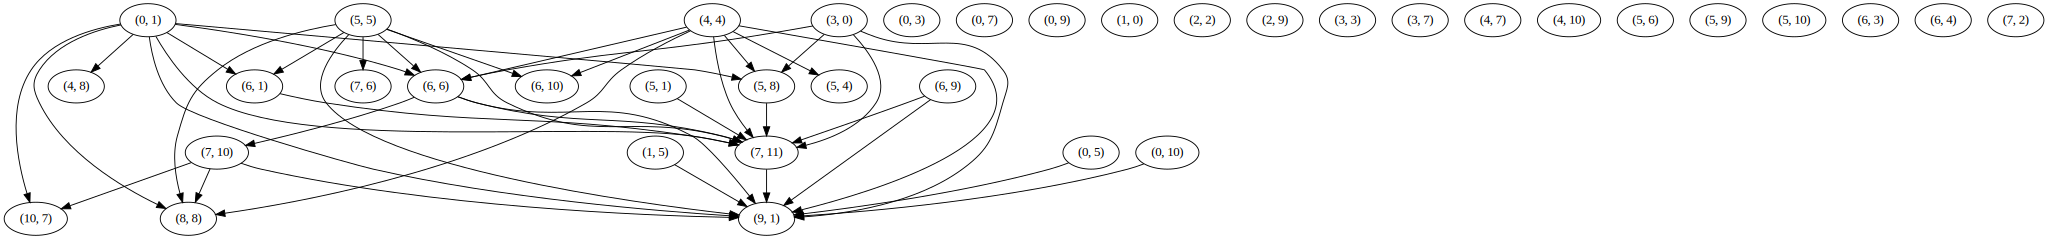

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph"):
    dot = Digraph()

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph
        dot.node(str(end_node))

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph
            dot.node(str(start))
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

plot_graph_adjacency(head_adjList)

In [ ]:
imshow(
    100 * results_dict[(7,11)],
    title="Direct effect on 7.11 Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

In [ ]:
head_adjList[(7,11)]

[(0, 1), (3, 0), (4, 4), (5, 1), (5, 5), (5, 8), (6, 1), (6, 6), (6, 9)]

In [ ]:
import pickle
with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

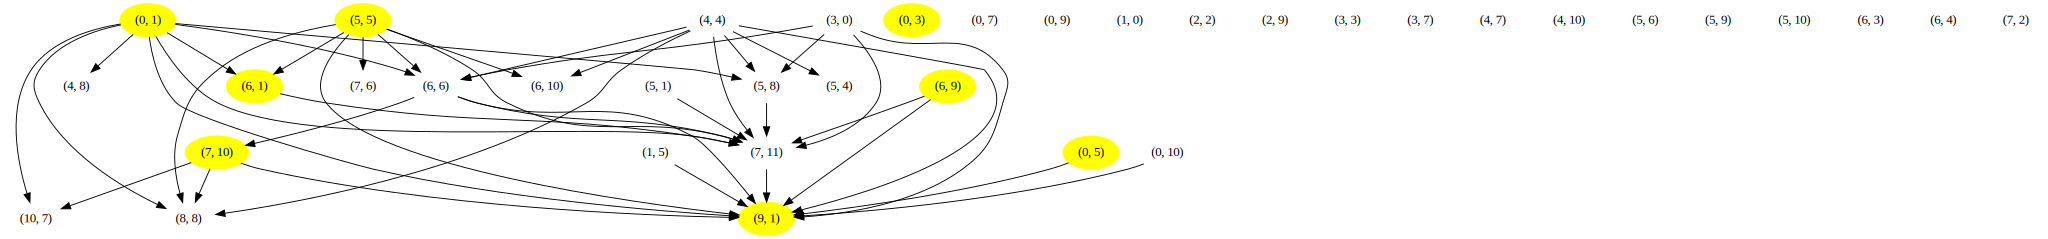

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "yellow" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        dot.node(str(end_node), color=get_node_color(end_node), style='filled')

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph with potential color
            dot.node(str(start), color=get_node_color(start), style='filled')
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

## Get Edges by Logit Diff Threshold 0.00001

In [ ]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

# Example usage:
threshold_value = 0.00001
pairs_within_threshold = edges_within_threshold(results, threshold_value)
print(pairs_within_threshold)

[(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 7), (1, 9), (1, 11)]


In [ ]:
%%capture
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = edges_within_threshold(result, threshold_value)

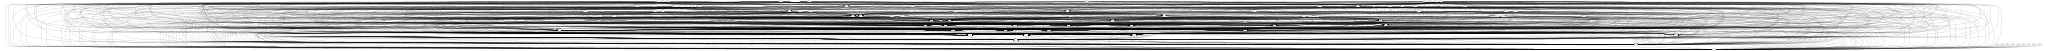

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.805363 to fit


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph"):
    dot = Digraph()

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph
        dot.node(str(end_node))

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph
            dot.node(str(start))
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

plot_graph_adjacency(head_adjList)

In [ ]:
imshow(
    100 * results_dict[(7,11)],
    title="Direct effect on 7.11 Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

In [ ]:
head_adjList[(7,11)]

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11)]

In [ ]:
import pickle
with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

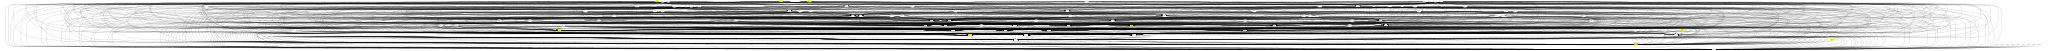

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.805363 to fit


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "yellow" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        dot.node(str(end_node), color=get_node_color(end_node), style='filled')

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph with potential color
            dot.node(str(start), color=get_node_color(start), style='filled')
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

## Get Edges by Logit Diff Threshold 0.001

In [ ]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

# Example usage:
threshold_value = 0.001
pairs_within_threshold = edges_within_threshold(results, threshold_value)
print(pairs_within_threshold)

[]


In [ ]:
%%capture
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = edges_within_threshold(result, threshold_value)

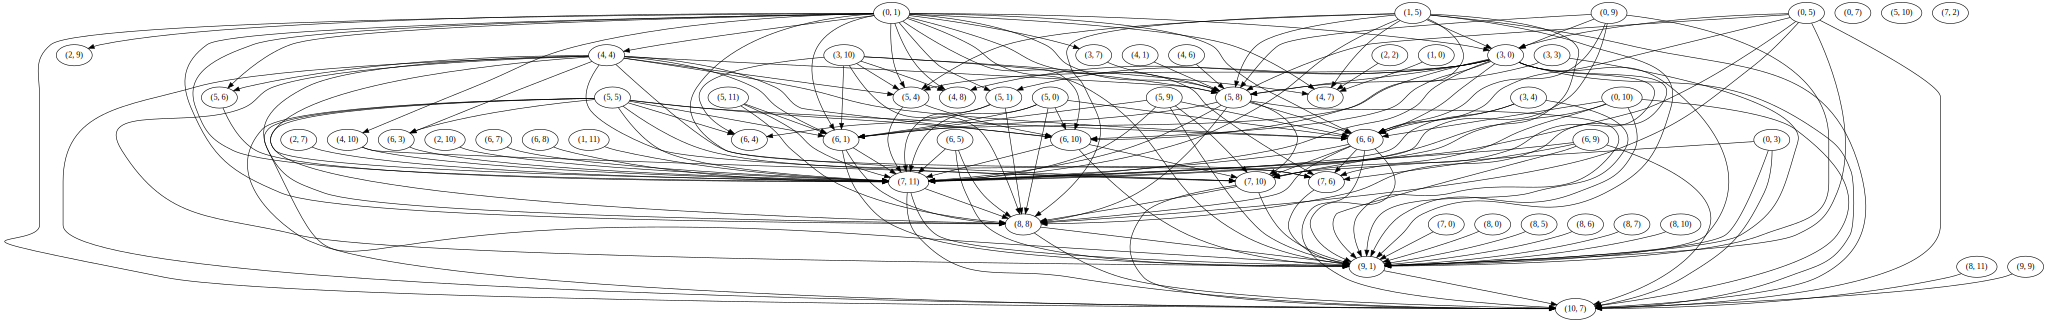

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph"):
    dot = Digraph()

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph
        dot.node(str(end_node))

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph
            dot.node(str(start))
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

plot_graph_adjacency(head_adjList)

In [ ]:
imshow(
    100 * results_dict[(7,11)],
    title="Direct effect on 7.11 Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

In [ ]:
head_adjList[(7,11)]

[(0, 1),
 (0, 5),
 (0, 9),
 (0, 10),
 (1, 5),
 (1, 11),
 (2, 7),
 (2, 10),
 (3, 0),
 (3, 4),
 (4, 4),
 (4, 10),
 (5, 0),
 (5, 1),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 8),
 (5, 9),
 (5, 11),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10)]

In [ ]:
import pickle
with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

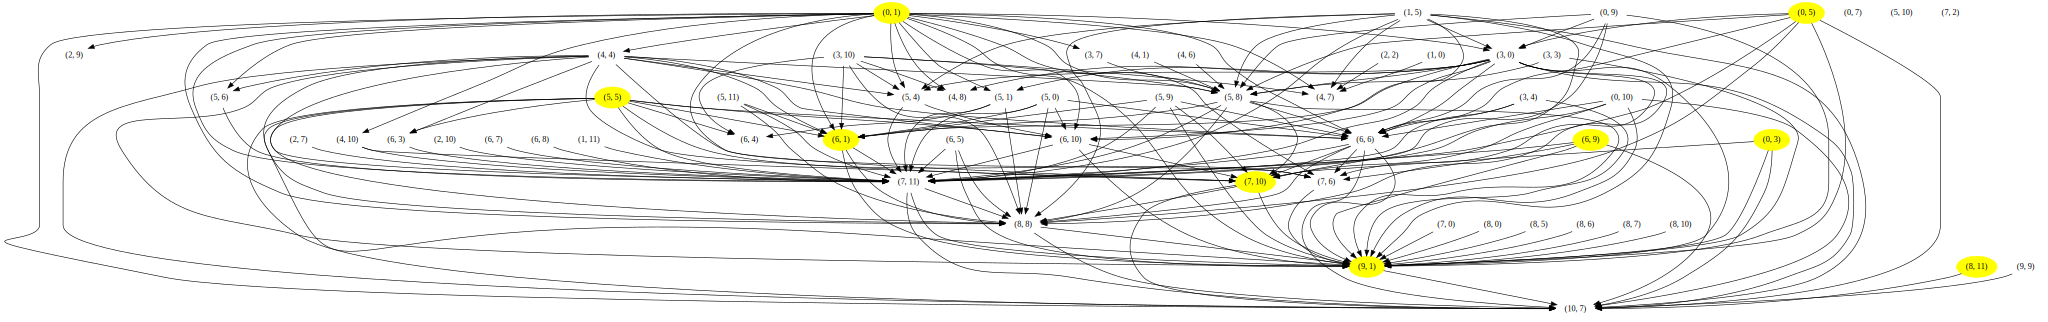

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "yellow" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        dot.node(str(end_node), color=get_node_color(end_node), style='filled')

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph with potential color
            dot.node(str(start), color=get_node_color(start), style='filled')
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

## Get Edges by Logit Diff Threshold 0.002

In [ ]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

# Example usage:
threshold_value = 0.002
# pairs_within_threshold = edges_within_threshold(results, threshold_value)
# print(pairs_within_threshold)

In [ ]:
%%capture
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = edges_within_threshold(result, threshold_value)

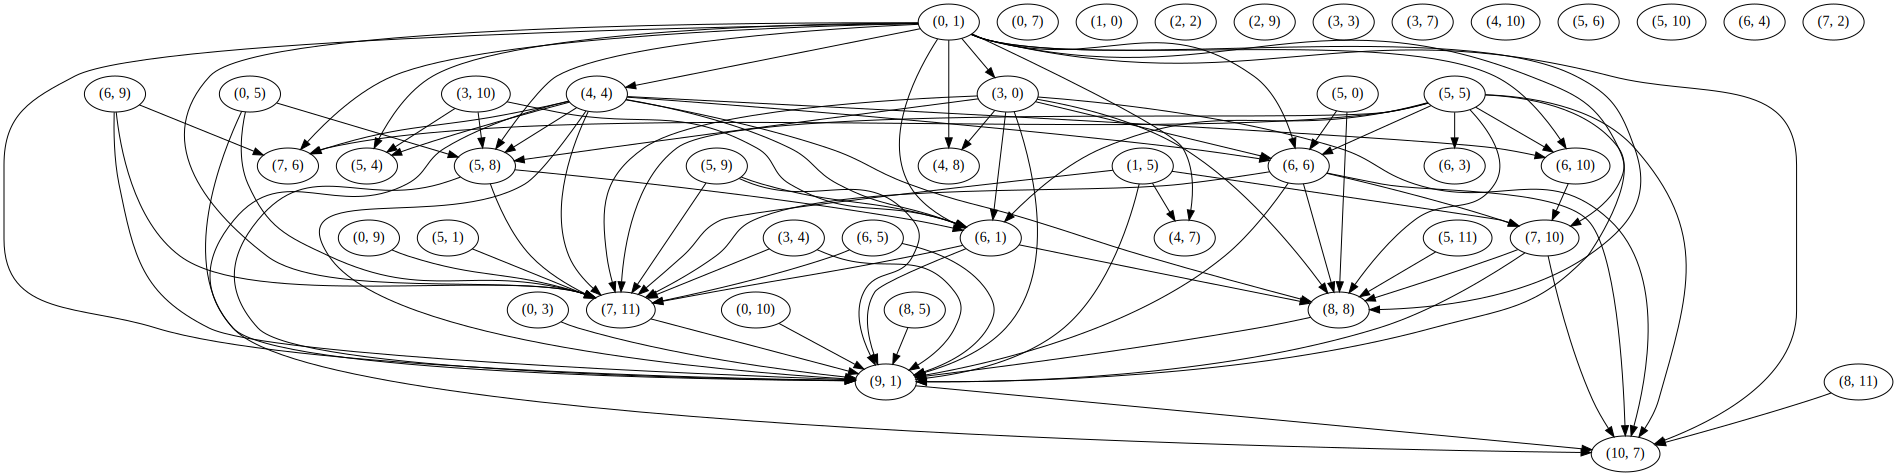

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph"):
    dot = Digraph()

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph
        dot.node(str(end_node))

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph
            dot.node(str(start))
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

plot_graph_adjacency(head_adjList)

In [ ]:
imshow(
    100 * results_dict[(7,11)],
    title="Direct effect on 7.11 Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

In [ ]:
head_adjList[(7,11)]

[(0, 1),
 (0, 5),
 (0, 9),
 (1, 5),
 (3, 0),
 (3, 4),
 (4, 4),
 (5, 1),
 (5, 5),
 (5, 8),
 (5, 9),
 (6, 1),
 (6, 5),
 (6, 6),
 (6, 9)]

In [ ]:
import pickle
with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

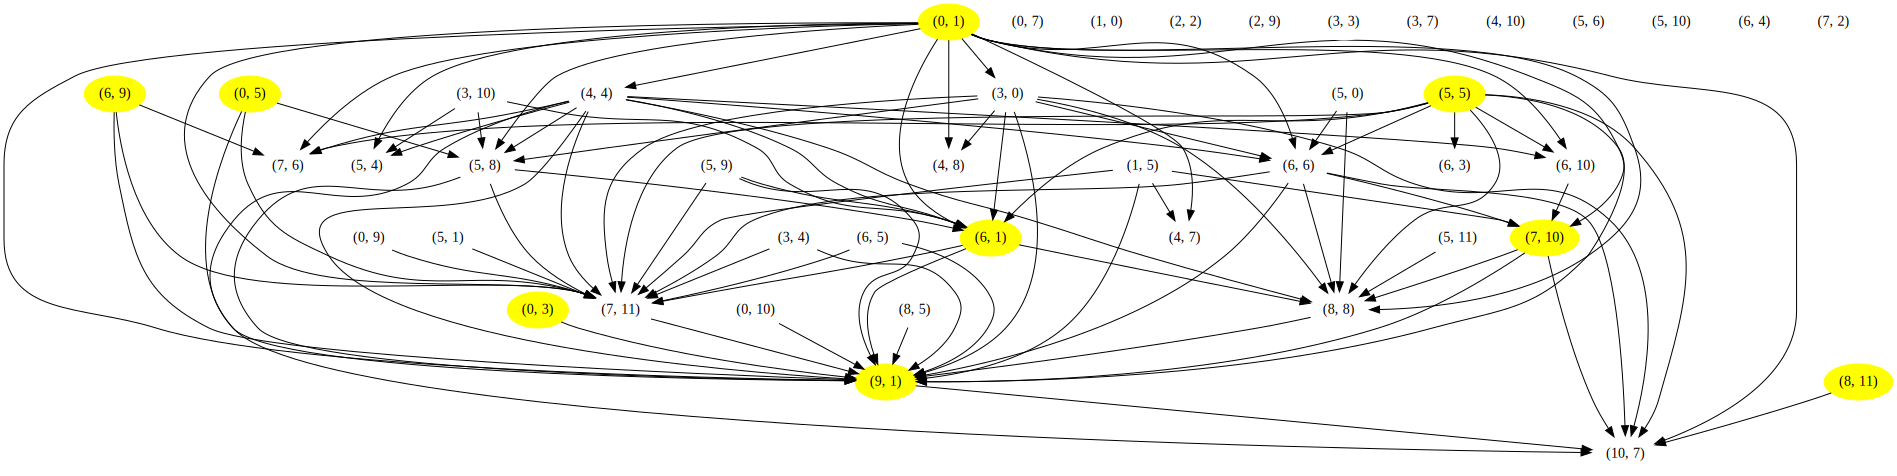

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "yellow" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        dot.node(str(end_node), color=get_node_color(end_node), style='filled')

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph with potential color
            dot.node(str(start), color=get_node_color(start), style='filled')
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

## Get Edges by Logit Diff Threshold 0.003

In [ ]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

# Example usage:
threshold_value = 0.003
pairs_within_threshold = edges_within_threshold(results, threshold_value)
print(pairs_within_threshold)

[]


In [ ]:
%%capture
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = edges_within_threshold(result, threshold_value)

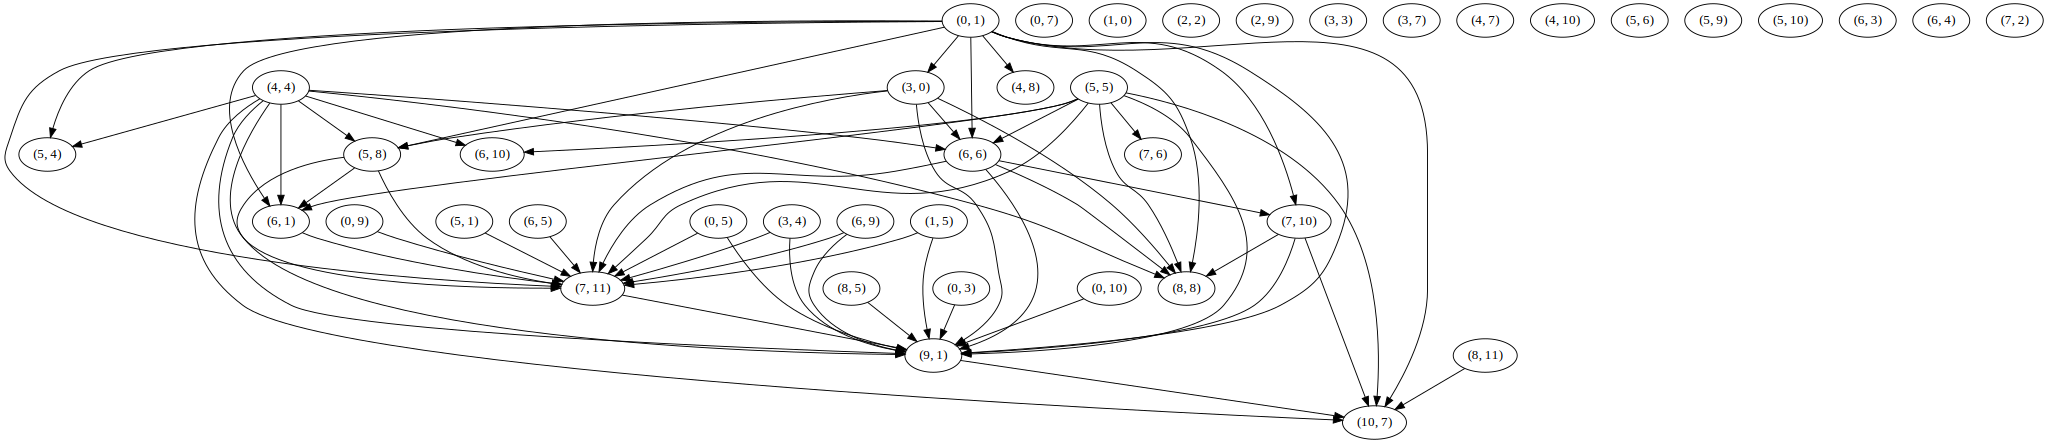

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph"):
    dot = Digraph()

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph
        dot.node(str(end_node))

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph
            dot.node(str(start))
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

plot_graph_adjacency(head_adjList)

In [ ]:
imshow(
    100 * results_dict[(7,11)],
    title="Direct effect on 7.11 Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff.<br>variation"},
    width=600,
    coloraxis=dict(colorbar_ticksuffix = "%"),
)

In [ ]:
head_adjList[(7,11)]

[(0, 1),
 (0, 5),
 (0, 9),
 (1, 5),
 (3, 0),
 (3, 4),
 (4, 4),
 (5, 1),
 (5, 5),
 (5, 8),
 (6, 1),
 (6, 5),
 (6, 6),
 (6, 9)]

In [ ]:
import pickle
with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

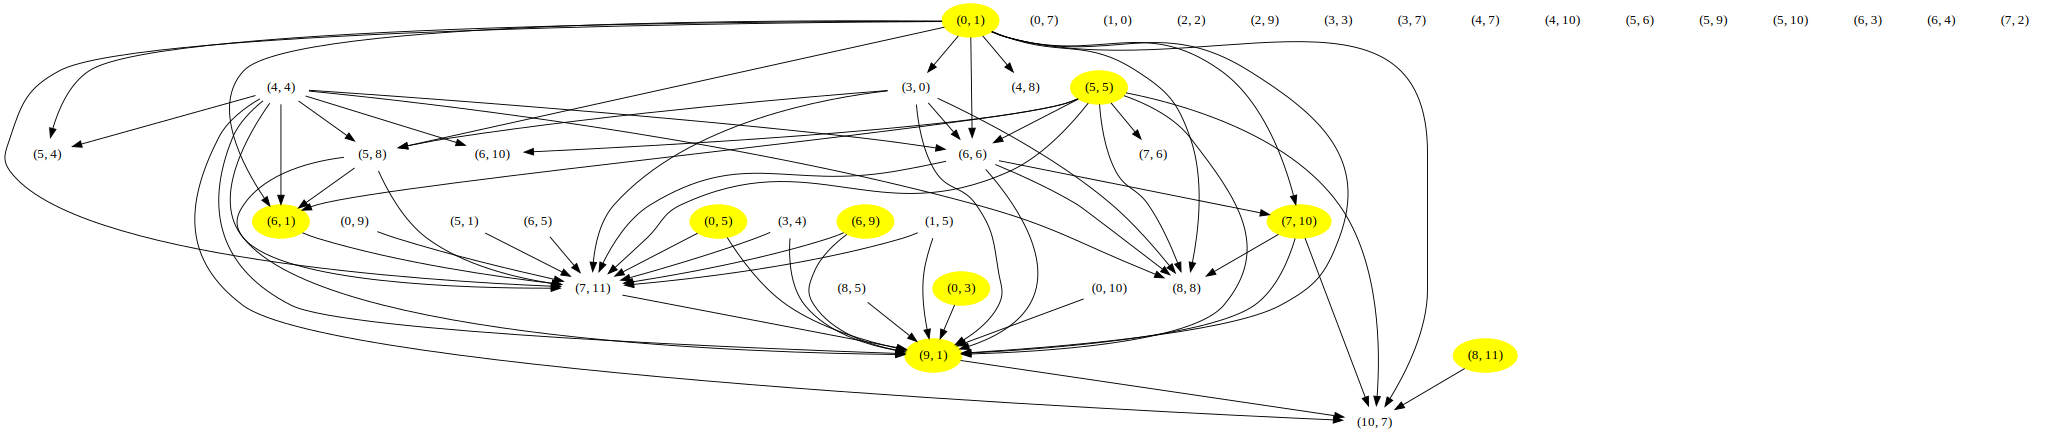

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "yellow" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        dot.node(str(end_node), color=get_node_color(end_node), style='filled')

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph with potential color
            dot.node(str(start), color=get_node_color(start), style='filled')
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

## open pickle and convert to heads list

in head_adjList, remove all nodes (a tuple) which do not have a path to 9.1, or which do not have outgoing edges to any other node

https://chat.openai.com/c/7b84abf2-a199-44a4-a6c4-b97d956d2ea8

In [ ]:
import pickle
with open('head_adjList.pkl', 'rb') as file:
    head_adjList = pickle.load(file)

In [ ]:
# def has_path(source, target, adjList, visited=None):
#     """Check if there's a path from source to target using DFS."""
#     if visited is None:
#         visited = set()

#     if source == target:
#         return True

#     visited.add(source)

#     for neighbor in adjList.get(source, []):
#         if neighbor not in visited:
#             if has_path(neighbor, target, adjList, visited):
#                 return True

#     return False

# # List of nodes to be kept
# nodes_to_keep = set()

# for node in head_adjList:
#     if has_path(node, (9, 1), head_adjList) and head_adjList[node]:
#         nodes_to_keep.add(node)

# # Filter the dictionary to keep only nodes in nodes_to_keep
# head_adjList = {node: head_adjList[node] for node in nodes_to_keep}

forget about paths to 9.1 for now, just write code to remove all nodes without outgoing edges except 9.1

In [ ]:
# Filter out nodes that don't have outgoing edges except for (9,1)
head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1)}

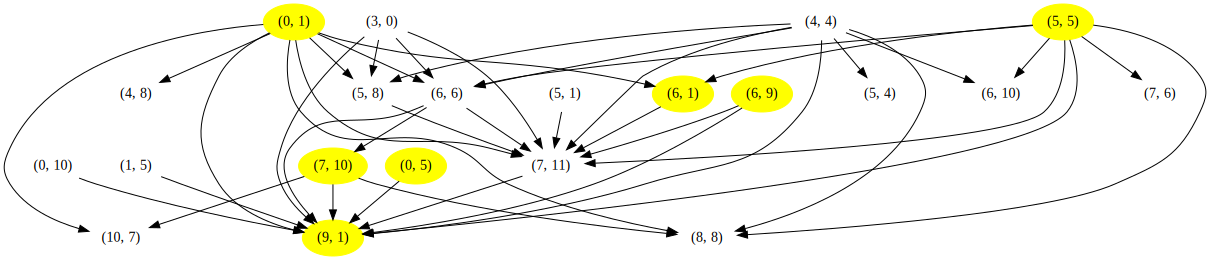

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "yellow" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        dot.node(str(end_node), color=get_node_color(end_node), style='filled')

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph with potential color
            dot.node(str(start), color=get_node_color(start), style='filled')
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

In [ ]:
head_adjList[4,8]

[(0, 1)]

In [ ]:
nodes_set = set(head_adjList.keys())  # adding all starting nodes

# adding all ending nodes
for neighbors in head_adjList.values():
    nodes_set.update(neighbors)

nodes_list = list(nodes_set)
nodes_list = sorted(nodes_list)
print(nodes_list)

[(0, 1), (0, 5), (0, 10), (1, 5), (3, 0), (4, 4), (4, 8), (5, 1), (5, 4), (5, 5), (5, 8), (6, 1), (6, 6), (6, 9), (6, 10), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]


## try again

keys of the head_adjList dictionary are nodes with INCOMING edges, not outgoing edges

In [ ]:
import pickle
with open('head_adjList.pkl', 'rb') as file:
    head_adjList = pickle.load(file)

In [ ]:
# Step 1: Identify nodes with incoming edges
nodes_with_incoming_edges = set(head_adjList.keys())

# Step 2: Identify nodes with outgoing edges
nodes_with_outgoing_edges = set()
for outgoing_list in head_adjList.values():
    nodes_with_outgoing_edges.update(outgoing_list)

# Step 3: Combine the lists
all_relevant_nodes = nodes_with_incoming_edges.union(nodes_with_outgoing_edges)

# Step 4: Retain (9,1)
all_relevant_nodes.add((9,1))

# Step 5: Remove irrelevant nodes from the graph
for node in list(head_adjList.keys()):  # Convert to list to avoid dict size change during iteration
    if node not in all_relevant_nodes:
        del head_adjList[node]

# Remove irrelevant destination nodes in the adjacency list
for source_node, destinations in head_adjList.items():
    head_adjList[source_node] = [dest for dest in destinations if dest in all_relevant_nodes]


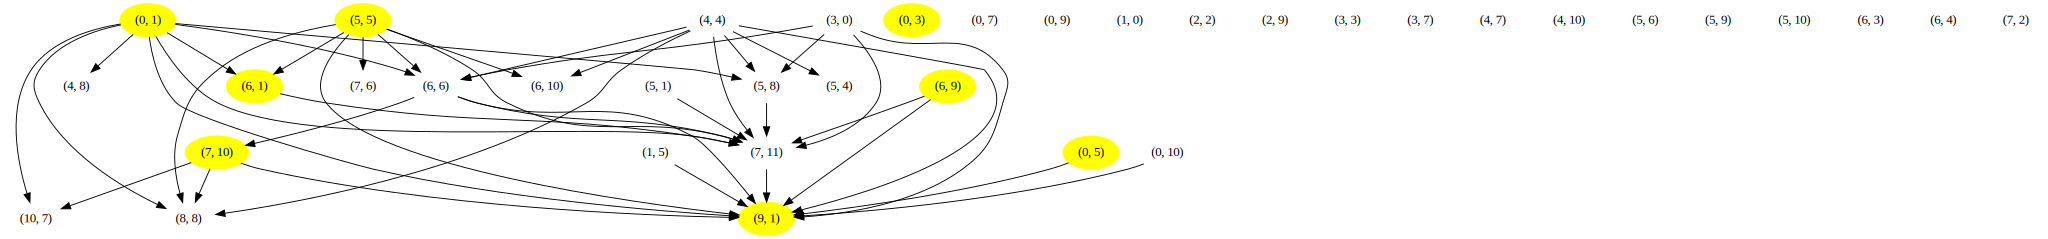

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

## iter patch over circ from fwd prune

In [ ]:
backw_prune_circ = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (4, 7), (4, 8), (4, 10), (5, 1), (5, 4), (5, 5), (5, 6), (5, 8), (5, 9), (5, 10), (6, 1), (6, 3), (6, 4), (6, 6), (6, 10), (7, 2), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]

In [ ]:
fwd_prune_circ = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 8), (0, 9), (0, 10), (1, 0), (1, 5), (3, 0), (3, 3), (3, 7), (3, 10), (3, 11), (4, 4), (4, 6), (4, 7), (4, 8), (4, 10), (4, 11), (5, 4), (5, 5), (5, 9), (6, 1), (6, 6), (6, 10), (7, 6), (7, 10), (7, 11), (8, 1), (8, 2), (8, 6), (8, 8), (9, 1), (9, 5), (10, 7), (11, 10)]

In [ ]:
set(backw_prune_circ) - set(fwd_prune_circ)

{(2, 2), (2, 9), (5, 1), (5, 6), (5, 8), (5, 10), (6, 3), (6, 4), (7, 2)}

In [ ]:
set(fwd_prune_circ) - set(backw_prune_circ)

{(0, 8),
 (3, 10),
 (3, 11),
 (4, 6),
 (4, 11),
 (8, 1),
 (8, 2),
 (8, 6),
 (9, 5),
 (11, 10)}

In [ ]:
%%capture
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 8), (0, 9), (0, 10), (1, 0), (1, 5), (3, 0), (3, 3), (3, 7), (3, 10), (3, 11), (4, 4), (4, 6), (4, 7), (4, 8), (4, 10), (4, 11), (5, 4), (5, 5), (5, 9), (6, 1), (6, 6), (6, 10), (7, 6), (7, 10), (7, 11), (8, 1), (8, 2), (8, 6), (8, 8), (9, 1), (9, 5), (10, 7), (11, 10)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = top_layer_heads_for_abs(result, 5)

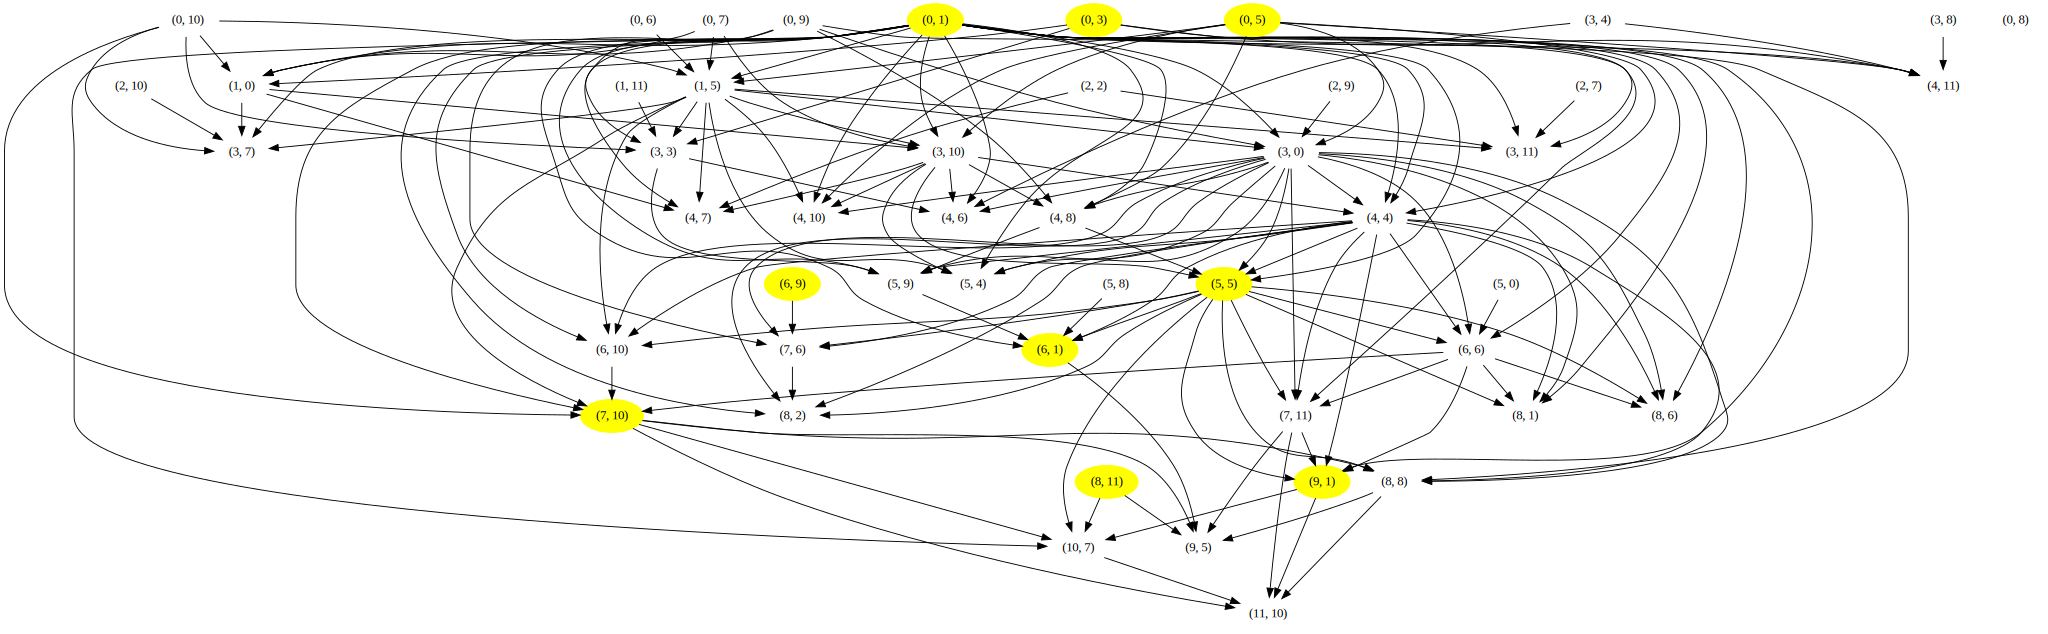

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "yellow" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        dot.node(str(end_node), color=get_node_color(end_node), style='filled')

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph with potential color
            dot.node(str(start), color=get_node_color(start), style='filled')
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

In [ ]:
import pickle
with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## iter patch from full T 0.01

Takes approx 10 min

In [ ]:
%%capture
circuit = [(layer, head) for layer in range(12) for head in range(12)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    # head_adjList[head] = top_layer_heads_for_abs(result, 5)

Use threshold

In [ ]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

In [ ]:
%%capture
circuit = [(layer, head) for layer in range(12) for head in range(12)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = edges_within_threshold(result, 0.01)

In [ ]:
import copy
head_adjList_copy = copy.deepcopy(head_adjList)

In [ ]:
# Filter out nodes that don't have outgoing edges except for (9,1)
head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1)}

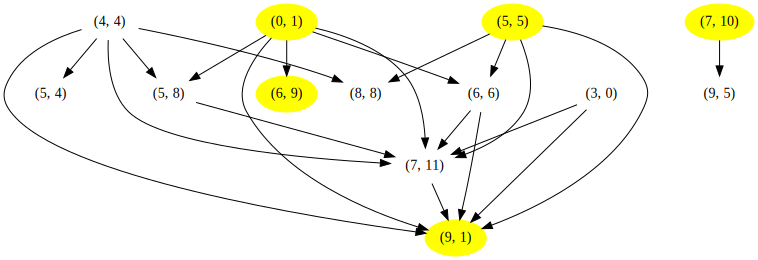

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

In [ ]:
with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList_copy, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## iter patch from full T 0.002

Takes approx 10 min

In [ ]:
%%capture
circuit = [(layer, head) for layer in range(12) for head in range(12)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = top_layer_heads_for_abs(result, 5)

NameError: ignored

Use threshold

In [ ]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

In [ ]:
%%capture
circuit = [(layer, head) for layer in range(12) for head in range(12)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = s_inhibition_value_path_patching_results = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = edges_within_threshold(result, 0.002)

In [ ]:
import copy
head_adjList_copy = copy.deepcopy(head_adjList)

In [ ]:
# Filter out nodes that don't have outgoing edges except for (9,1)
head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1)}

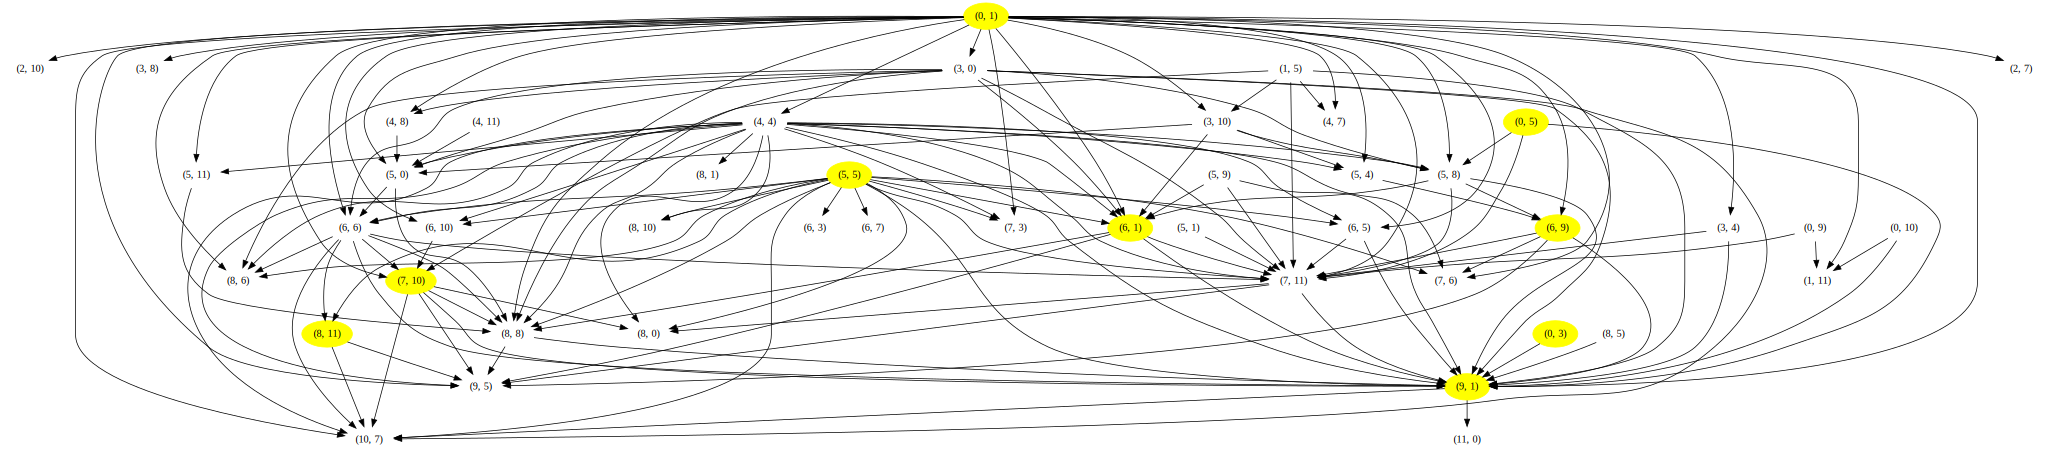

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

In [ ]:
with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList_copy, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## iter patch from manual sel

This has 75% perf: https://colab.research.google.com/drive/1CHRn-AMko9RNrl1bqiCwB7DS-rz1CoBP#scrollTo=olCvIneV_lzg&line=2&uniqifier=1

Use E threshold 0.002

In [27]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

In [28]:
%%capture
# V1 plus L0, L2, L3, L6 minus 6.3, 6.4
circuit = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 10), (1, 5), (2, 2), (2, 9), (3, 0), (3, 3), (3, 7), (4, 4), (5, 5), (6, 1), (6, 6), (6, 9), (6, 10), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]

results_dict = {}
head_adjList = {}
for head in circuit:
    model.reset_hooks()
    result = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )

    results_dict[head] = result
    head_adjList[head] = edges_within_threshold(result, 0.002)

In [29]:
import copy
head_adjList_copy = copy.deepcopy(head_adjList)

In [32]:
# Filter out nodes that don't have outgoing edges except for (9,1) and (10, 7)
head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1) or node == (10,7)}

In [35]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "yellow" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        dot.node(str(end_node), color=get_node_color(end_node), style='filled')

        for start in start_nodes_list:
            # Ensure start is present as a node in the graph with potential color
            dot.node(str(start), color=get_node_color(start), style='filled')
            # Create edge from start to end_node
            dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'svg', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]

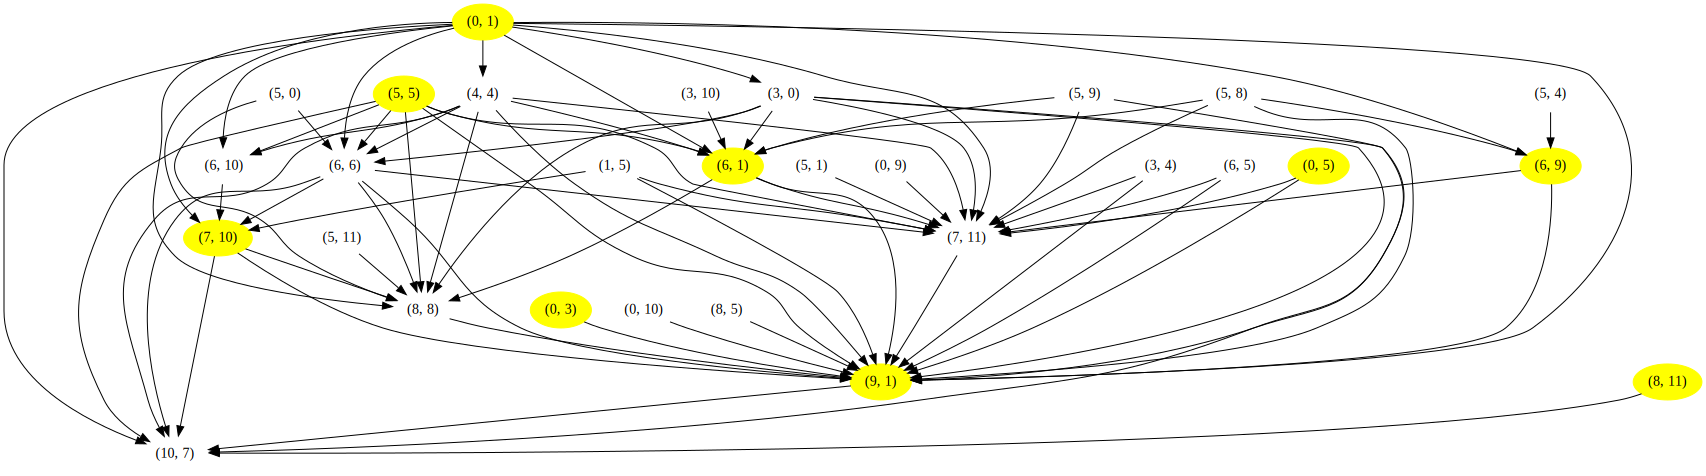

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
plot_graph_adjacency(head_adjList, highlighted_nodes=greater_than)

In [38]:
import pickle

with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList_copy, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>